In [16]:


import gymnasium as gym
import numpy as np
from IPython.utils import io

import keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt 

from IPython.display import clear_output
from IPython.utils import importstring

import os
os.environ['KERAS_BACKEND'] = "torch"

In [17]:
# The environment is created
# https://gymnasium.farama.org/environments/classic_control/cart_pole/
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

### DQN Hyperparameters

In [18]:
# hyperparameters
gamma = 0.99
epsilon = 1.0

# remember: Cart Pole is extremely sensitive to inputs
# you probably need a very low epsilon in the end of the training
epsilon_min = 0.015

# in DQN-networks we usually use a MULTIPLIER -version of decay
# after each episode => multiply epsilon with 0.99 etc. instead 
# reducing the epsilon with a constant step-by-step reduction like 0.00025
epsilon_decay = 0.9925

# neural network-specific hyperparameters
# please note: this is the neural network learning rate
# we are going to skip the Q-learning learning rate because of this
learning_rate = 0.01

# this is the target "goal" of our agent
# if the agent is able to play the environment for 350 steps WITHOUT failing => win the game
max_steps = 500

# similar to usual neural network batch size
# the bigger the batch size, the faster the training and vice versa
# by default, batch size should not affect the quality of the training
# but in case of reinforcement learning, we'll have to double-check
batch_size = 32 

# "max epochs" -> episodes are basically the epochs of reinforcement learning
max_episodes = 500

# replay buffer capacity: usually simple environments work with small capacities 
# (1000-5000), more complex environments are usually 10000+ in capacity size
buffer_capacity = 1000

# Q-network and target network parameters
# train_steps => how often the Q-network values are updated
q_network_train_step_interval = 4

# how often the target network values are updated
target_step_update_interval = 128

####  Basic DQN replay buffer is usually more or less like this

In [19]:
# Replay buffer / experience replay -class
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity

        # list that stores the experiences
        self.buffer = []

         # pointer to the current position in the buffer
        self.position = 0

    # if the buffer is full, the new experience will overwrite the oldest experience
    def store(self, experience): 
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = experience

        # update the position pointer
        self.position = (self.position + 1) % self.capacity 
        
    # randomly sample a batch of experiences for our DQN
    def sample(self, batch_size): 
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)

#### Build the neural networks (Q-network + target network)

In [20]:
# make a helper function to build a q-network
def build_q_network():
    # basic idea => observations go in, actions come out
    # you can adjust the details of the network as you wish
    # have more layers, more nodes etc. most of the same things
    # we used already in Deep Learning
    model = Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_dim,)),
        layers.Dense(action_dim, activation='linear')
    ])

    # compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="mse")
    return model

# initialize Q-network AND the target network
q_network = build_q_network()

# we use the same "blueprint" for the target network as the q-network
# because is essentially a reference network to q-network
target_network = build_q_network()

# SYNCHRONIZE the initial state between both networks -> IMPORTANT STEP
# otherwise the networks have different starting points
# and the target network is not very helpful as a reference for the q-network
target_network.set_weights(q_network.get_weights())

# INITIALIZE the replay buffer
replay_buffer = ReplayBuffer(buffer_capacity)

####  Helper functions: epsilon function + train step -function

In [21]:
# helper function for handling the epsilon (exploration vs. exploitation)
# this basic epsilon implementation is known as "epsilon-greedy"
# compare this to the typical exploration/exploitation
# in previous FrozenLake and MountainCar, same principle
# different implementation
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        # take a random action -> exploration
        return np.random.choice(action_dim)
    
    # use the existing Q-values of the agent -> exploitation
    # we have to match the state's data format into neural network -format
    state = np.expand_dims(state, axis=0)

    # there's going to be lots of Keras/Torch -based extra message (output)
    # use io.capture_output() to suppress them
    with io.capture_output() as captured:
        # this is basically the same as getting the best value from the current
        # Q-table in classical Q-learning
        q_values = q_network.predict(state)

    # return best action decided by current model => either go left or right
    return np.argmax(q_values)


# training loop helper function for the DQN
# in your exercise project 3 => this is a very good function to study 
# in more detail, since this is basically the way how we can adapt
# the goals of reinforcement learning to work with basic neural networks as well
def train_step():
    # in the beginning of the training, we don't have enough data in
    # the buffer (compared to batch size), we'll have to wait
    if replay_buffer.size() < batch_size:
        return
    
    # if we have enough samples, we continue here
    batch = replay_buffer.sample(batch_size)

    # COMPARE THIS ON how we unpack the observation
    # in classical Q-learning, we just have a batch of observations this time
    states, actions, rewards, next_states, dones = batch

    # predict Q-values for the current and next state using the Q-network
    state_q_values = q_network.predict(states, verbose=0)
    next_state_q_values = target_network.predict(next_states, verbose=0)

    # take a copy of the state values so we can update them in the loop below
    targets = state_q_values.copy()

    # compute target q-values => basically same as Q-targets in Bellman/Q-learning -equation
    # BUT WITHOUT LEARNING RATE
    for i in range(batch_size):
        if dones[i]:
            targets[i, actions[i]] = rewards[i]
        else:
            # this is essentially the Bellman/Q-learning -equation, COMPARE TO EARLIER EXERCISES
            targets[i, actions[i]] = rewards[i] + gamma * np.max(next_state_q_values[i])

    # finally, update the Q-network based on the targets we just created 
    # "out of nowhere" -> from the past experiences in replay buffer
    with io.capture_output() as captured:
        loss = q_network.train_on_batch(states, targets)
        return loss

#### Training loop (uses helper functions + replay buffer from earlier)

In [22]:
# let's have some helper lists to capture data for metrics
losses = []
rewards = []
variances = []

# initalize total steps
total_steps = 0

# training loop -> compare this to previous Q-learning examples as well!
for episode in range(max_episodes):
    state, info = env.reset()
    total_reward = 0

    # start training until max_steps
    for step in range(max_steps):
        # decide what action to take (exploration/exploitation)
        action = select_action(state, epsilon)

        # take the action in the environment
        next_state, reward, done, truncated, info = env.step(action)

        # store the transition into the replay buffer
        replay_buffer.store((state, action, reward, next_state, done))

        # update the state for future
        state = next_state
        total_reward += reward
        total_steps += 1

        # PERFORM THE ACTUAL TRAINING STEP FOR THE Q-NETWORK
        # if current total_steps is divisible by 4 EXACTLY =>
        if total_steps % q_network_train_step_interval == 0:
            loss = train_step()
            losses.append(loss)

        # UPDATE THE TARGET NETWORK AS WELL IF THE INTERVAL MATCHES
        # in this case => if it's divisible exactly with 128
        if total_steps % target_step_update_interval == 0:
            # re-synchronize the target network
            target_network.set_weights(q_network.get_weights())
            
        # if the game has ended
        if done:
            break

    # the usual, apply decay to epsilon
    # basically => multiply current epsilon by 0.99 (reduce by 1%)
    # but don't go below the minimum value
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # show progress while training
    print(f"Total steps: {total_steps}")
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

    # let's stop the training if we are satisfied with our results
    # basically if we have almost maxed out the score 
    # and the epsilon is no longer updating => no point continuing the training
    # kind of a version of "EarlyStop"
    if total_reward >= (max_steps - 5) and epsilon == epsilon_min:
        print(f"Solved Cart Pole in {episode + 1} episodes!")
        break

    # log the results for metrics
    rewards.append(total_reward)
    variances.append(np.var(rewards))
        

Total steps: 20
Episode 1: Total Reward = 20.00, Epsilon = 0.993
Total steps: 32
Episode 2: Total Reward = 12.00, Epsilon = 0.985
Total steps: 43
Episode 3: Total Reward = 11.00, Epsilon = 0.978
Total steps: 59
Episode 4: Total Reward = 16.00, Epsilon = 0.970
Total steps: 75
Episode 5: Total Reward = 16.00, Epsilon = 0.963
Total steps: 110
Episode 6: Total Reward = 35.00, Epsilon = 0.956
Total steps: 133
Episode 7: Total Reward = 23.00, Epsilon = 0.949
Total steps: 152
Episode 8: Total Reward = 19.00, Epsilon = 0.942
Total steps: 173
Episode 9: Total Reward = 21.00, Epsilon = 0.934
Total steps: 193
Episode 10: Total Reward = 20.00, Epsilon = 0.927
Total steps: 206
Episode 11: Total Reward = 13.00, Epsilon = 0.921
Total steps: 235
Episode 12: Total Reward = 29.00, Epsilon = 0.914
Total steps: 249
Episode 13: Total Reward = 14.00, Epsilon = 0.907
Total steps: 268
Episode 14: Total Reward = 19.00, Epsilon = 0.900
Total steps: 289
Episode 15: Total Reward = 21.00, Epsilon = 0.893
Total ste

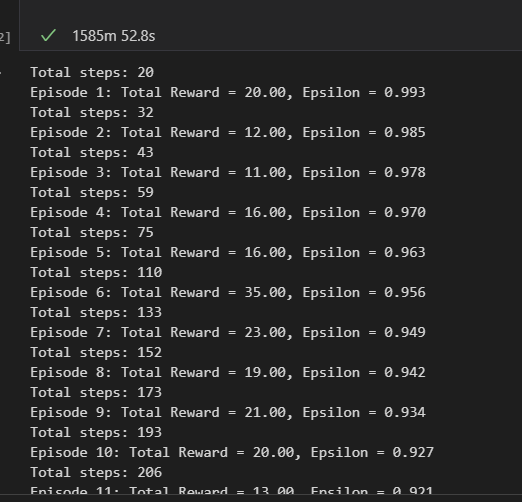

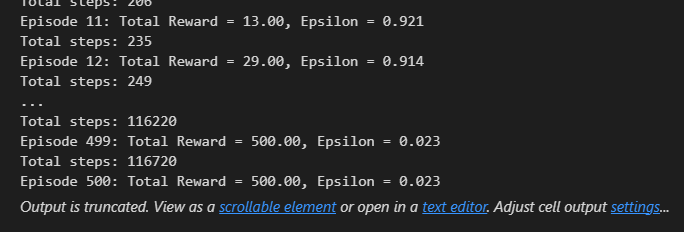

### Metrics (total rewards, running mean, variance over time, losses)

#### In the end of the day, in reinforcement learning applications, the actual performance of the agent matters most.

#### However, if the agent does not work well, metrics become useful then.

Variance over time


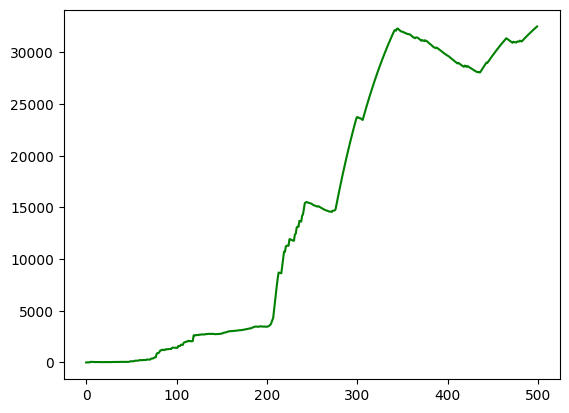

In [23]:
 # visualize variance over time
print("Variance over time")
plt.plot(variances, color="green")

# if variance rises but running mean doesn't, we might have an instability issue
# in this case, we usually need to adjust training parameters, hyperparameters (especially epsilon decay)
# or even the reward mechanism in the policy

Neural network losses over time


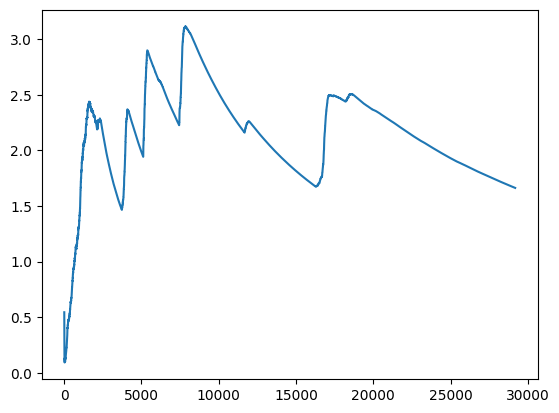

In [24]:
# visualize losses (neural network metrics)
print("Neural network losses over time")
plt.plot(losses)

# losses are as usual in neural networks => it can imply overfitting
# but it's also quite normal that the losses fluctuate even if the agent works well
# if agent does not work well => adjust hyperparameters, especially the learning rate

Rewards by episode


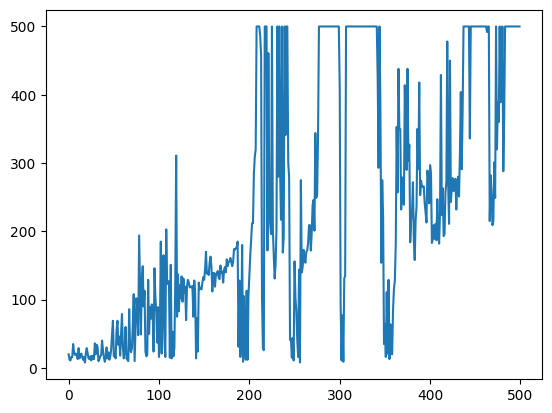

In [25]:
# let's see the rewards progression
print("Rewards by episode")
plt.plot(rewards)
plt.show()

Rewards w/ running mean:


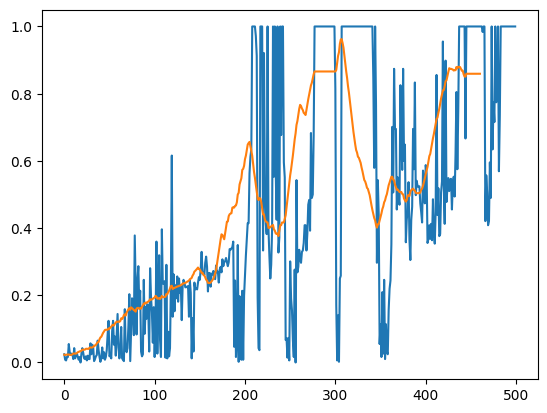

In [26]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average

# 50 is okay for 15000 episodes as the minimum window size
# if the running mean line is too noisy, adjust the window size
# rule of thumb: many episodes => bigger window_ize
# 15000 => 30-50 is okay for window size
window_size = 40

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

print("Rewards w/ running mean:")
# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

#### Finally: test the DQN-agent in the Cart Pole -environment

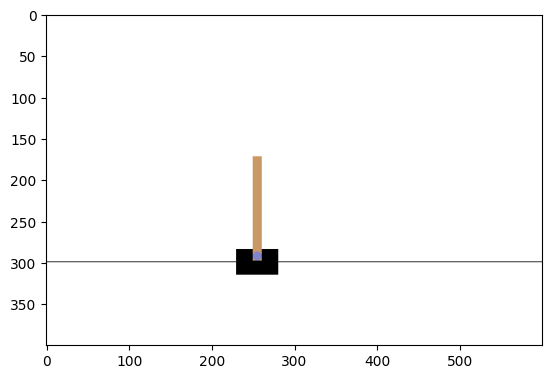

Total Reward: 1000.0


In [27]:
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(1000):
    action = select_action(state, epsilon)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    if done:
        break

# print result
print(f"Total Reward: {total_reward}")

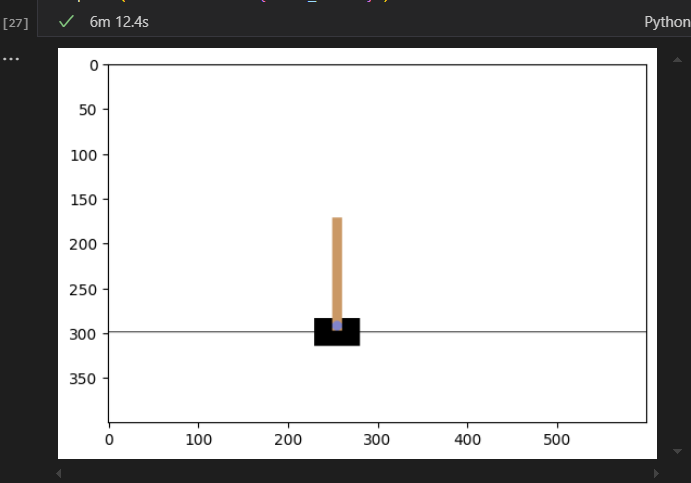